In [1]:
import sys
import os
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import torch
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from tqdm.auto import tqdm
import numpy as np

import shutil

In [2]:
RAW_DATA_DIR = "raw/tdrive"
PROCESSED_DATA_DIR = "processed"
raw_data = Path(RAW_DATA_DIR) / "taxi_log_2008_by_id"

In [18]:
DATA = {}

participant_files = list(raw_data.glob("*.txt"))
for idx, participant_file in enumerate(participant_files, start=1):
    print(f"Processing {idx}/{len(participant_files)}: {participant_file.name}")
    df = pd.read_csv(participant_file, header=None, usecols=[1, 2, 3], names=['datetime', 'longitude', 'latitude'])
    df['timestamp'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S').astype(np.int64) / 10**9
    DATA[int(participant_file.name.split('.')[0])] = df
print(DATA[1].head())

Processing 1/10357: 1.txt
Processing 2/10357: 10.txt
Processing 3/10357: 100.txt
Processing 4/10357: 1000.txt
Processing 5/10357: 10000.txt
Processing 6/10357: 10001.txt
Processing 7/10357: 10002.txt
Processing 8/10357: 10003.txt
Processing 9/10357: 10004.txt
Processing 10/10357: 10005.txt
Processing 11/10357: 10006.txt
Processing 12/10357: 10007.txt
Processing 13/10357: 10008.txt
Processing 14/10357: 10009.txt
Processing 15/10357: 1001.txt
Processing 16/10357: 10010.txt
Processing 17/10357: 10011.txt
Processing 18/10357: 10012.txt
Processing 19/10357: 10013.txt
Processing 20/10357: 10014.txt
Processing 21/10357: 10015.txt
Processing 22/10357: 10016.txt
Processing 23/10357: 10017.txt
Processing 24/10357: 10018.txt
Processing 25/10357: 10019.txt
Processing 26/10357: 1002.txt
Processing 27/10357: 10020.txt
Processing 28/10357: 10021.txt
Processing 29/10357: 10022.txt
Processing 30/10357: 10023.txt
Processing 31/10357: 10024.txt
Processing 32/10357: 10025.txt
Processing 33/10357: 10026.tx

In [19]:
empty_dfs = []
non_df_items = []

for idx, item in DATA.items():
    if not isinstance(item, pd.DataFrame):
        non_df_items.append(idx)
    elif item.empty:
        empty_dfs.append(idx)

if empty_dfs:
    print(f"Found {len(empty_dfs)} empty DataFrames with these keys: {empty_dfs}")
else:
    print("No empty DataFrames found in DATA.")
    
if non_df_items:
    print(f"Found {len(non_df_items)} items that are not DataFrames with these keys: {non_df_items}")

Found 21 empty DataFrames with these keys: [10115, 10352, 1089, 1497, 1947, 2929, 2945, 295, 3050, 3160, 3194, 3950, 5972, 6030, 6236, 6322, 6717, 7583, 8209, 8424, 9874]


In [20]:
for key in empty_dfs:
    if key in DATA:
        del DATA[key]

print(f"Removed {len(empty_dfs)} empty DataFrames from DATA dictionary.")
print(f"DATA dictionary now contains {len(DATA)} items.")

new_data = {}
for i, (old_key, df) in enumerate(DATA.items(), start=1):
    new_data[i] = df

DATA = new_data

Removed 21 empty DataFrames from DATA dictionary.
DATA dictionary now contains 10336 items.


In [21]:
import pickle

PROCESSED_DATA_DIR = "processed"

with open(os.path.join(PROCESSED_DATA_DIR, 'tdrive_next_point_routes.pkl'), 'wb') as f:
    pickle.dump(DATA, f)

print(f"Routes dataset saved to {os.path.join(PROCESSED_DATA_DIR, 'tdrive_next_point_routes.pkl')}")

Routes dataset saved to processed\tdrive_next_point_routes.pkl


In [22]:
import folium

df = DATA[105]
print("Number of dataframes for participant 105:", len(df))
print(df.info())

# Create a map centered around Beijing
beijing_map = folium.Map(location=[39.9042, 116.4074], zoom_start=12)

# Plot each route for participant
route = folium.PolyLine(
    locations=df[['latitude', 'longitude']].values,
    color='red',
    weight=2.5,
    opacity=1
)
route.add_to(beijing_map)

# Display the map
beijing_map

Number of dataframes for participant 105: 633
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633 entries, 0 to 632
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   633 non-null    object 
 1   longitude  633 non-null    float64
 2   latitude   633 non-null    float64
 3   timestamp  633 non-null    float64
dtypes: float64(3), object(1)
memory usage: 19.9+ KB
None


In [29]:
def separate_routes_by_date(df):
    """
    Separate a DataFrame into multiple DataFrames by date, keeping each sorted by datetime
    """
    df['date'] = pd.to_datetime(df['datetime']).dt.date
    
    date_groups = df.groupby('date')
    
    date_dfs = {}
    for date, group_df in date_groups:
        date_dfs[str(date)] = group_df.sort_values(by='datetime').reset_index(drop=True)
    
    return date_dfs

In [49]:
separated_routes_by_participant = {}

for participant_id, df in DATA.items():
    print(f"Separating routes for participant {participant_id}...")
    separated_routes_by_participant[participant_id] = {}
    
    routes = separate_routes_by_date(df)

    for date, route_df in routes.items():
        new_label = f"{participant_id}_route_{date}"
        separated_routes_by_participant[participant_id][new_label] = route_df

Separating routes for participant 1...
Separating routes for participant 2...
Separating routes for participant 3...
Separating routes for participant 4...
Separating routes for participant 5...
Separating routes for participant 6...
Separating routes for participant 7...
Separating routes for participant 8...
Separating routes for participant 9...
Separating routes for participant 10...
Separating routes for participant 11...
Separating routes for participant 12...
Separating routes for participant 13...
Separating routes for participant 14...
Separating routes for participant 15...
Separating routes for participant 16...
Separating routes for participant 17...
Separating routes for participant 18...
Separating routes for participant 19...
Separating routes for participant 20...
Separating routes for participant 21...
Separating routes for participant 22...
Separating routes for participant 23...
Separating routes for participant 24...
Separating routes for participant 25...
Separatin

C:\Users\raduc\AppData\Local\Temp\ipykernel_3980\2994490645.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['datetime']).dt.date


Separating routes for participant 7934...
Separating routes for participant 7935...
Separating routes for participant 7936...
Separating routes for participant 7937...
Separating routes for participant 7938...
Separating routes for participant 7939...
Separating routes for participant 7940...
Separating routes for participant 7941...
Separating routes for participant 7942...
Separating routes for participant 7943...
Separating routes for participant 7944...
Separating routes for participant 7945...
Separating routes for participant 7946...
Separating routes for participant 7947...
Separating routes for participant 7948...
Separating routes for participant 7949...
Separating routes for participant 7950...
Separating routes for participant 7951...
Separating routes for participant 7952...
Separating routes for participant 7953...
Separating routes for participant 7954...
Separating routes for participant 7955...
Separating routes for participant 7956...
Separating routes for participant 

In [50]:
participant_id = 105
participant_routes = separated_routes_by_participant[participant_id]
print(f"Number of routes for participant {participant_id}: {len(participant_routes)}")

beijing_map = folium.Map(location=[39.9042, 116.4074], zoom_start=12)
colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'pink', 'lightblue', 'lightgreen', 'gray']

for i, (label, route_df) in enumerate(list(participant_routes.items())):
    route = folium.PolyLine(
        locations=route_df[['latitude', 'longitude']].values,
        color=colors[i],
        weight=2.5,
        opacity=1,
        popup=f"Route: {label}"
    )
    route.add_to(beijing_map)

beijing_map

Number of routes for participant 105: 6


In [51]:
empty_routes_count = 0
participants_with_empty_routes = set()

for participant_id, routes in separated_routes_by_participant.items():
    empty_route_labels = []
    
    for route_label, route_df in routes.items():
        if len(route_df) == 0:
            empty_route_labels.append(route_label)
            empty_routes_count += 1
            participants_with_empty_routes.add(participant_id)
    
    for empty_label in empty_route_labels:
        del separated_routes_by_participant[participant_id][empty_label]

print(f"Removed {empty_routes_count} empty routes from {len(participants_with_empty_routes)} participants")
print(f"Participants affected: {sorted(list(participants_with_empty_routes))}")

Removed 0 empty routes from 0 participants
Participants affected: []


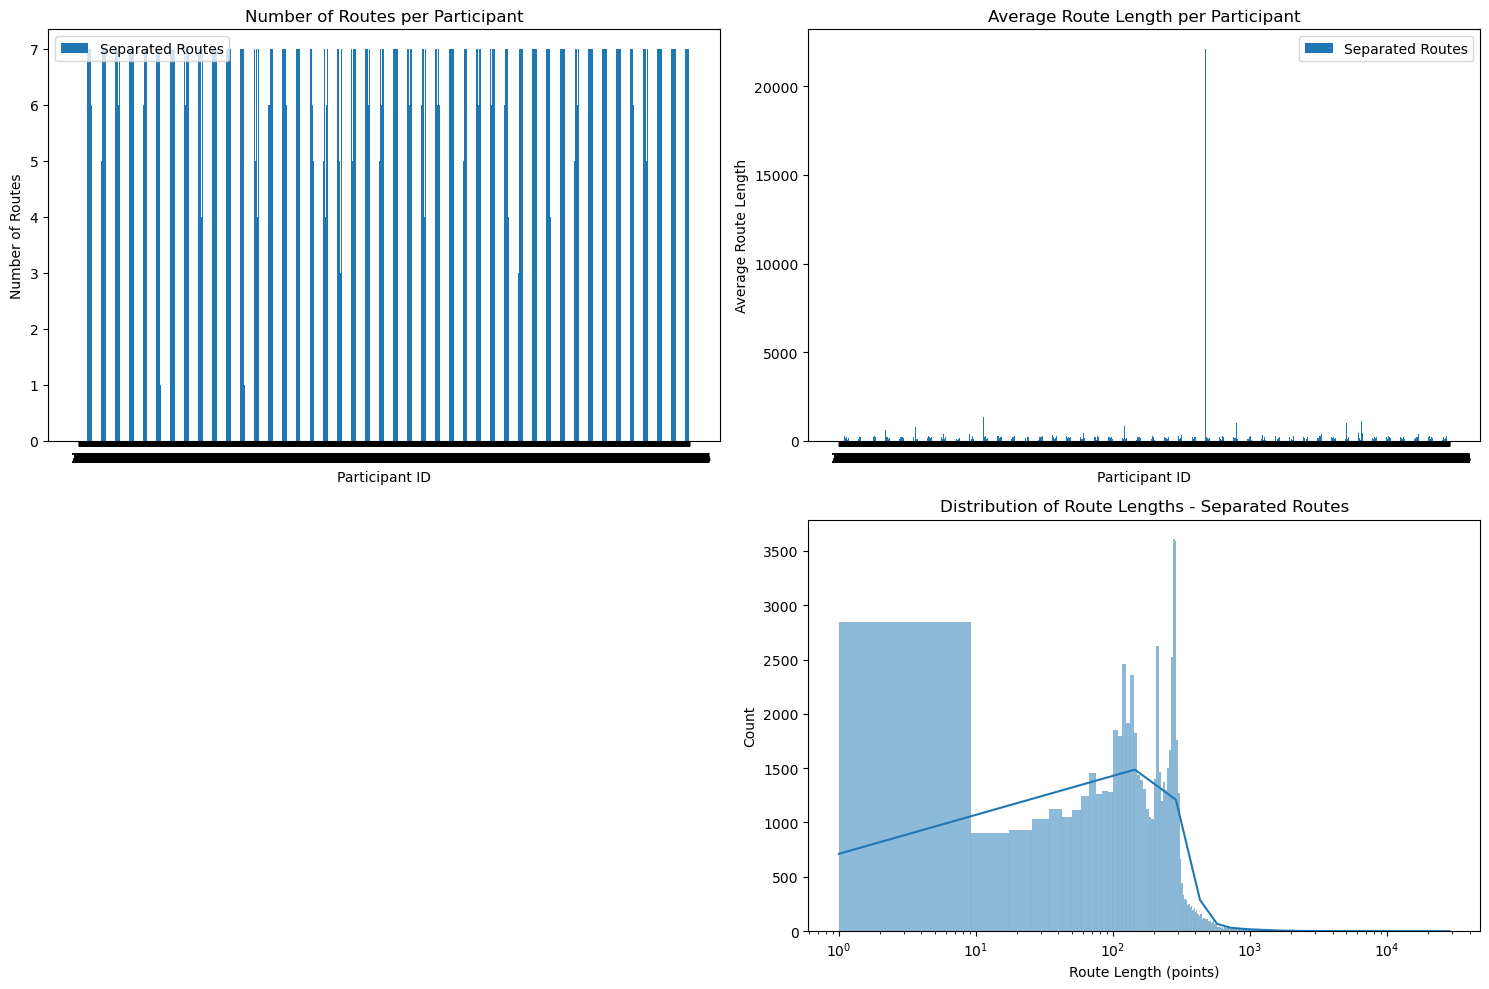

Separated routes total: 68872
Separated avg route length: 256.4610291555349


In [52]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

separated_routes_count = {p_id: len(dataframes) for p_id, dataframes in separated_routes_by_participant.items()}

separated_route_lengths = {}
for p_id, dataframes in separated_routes_by_participant.items():
    separated_route_lengths[p_id] = [len(df) for _, df in dataframes.items()]


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
participant_ids = list(separated_routes_count.keys())
sep_counts = [separated_routes_count[p] for p in participant_ids]

x = np.arange(len(participant_ids))
width = 0.35

plt.bar(x + width/2, sep_counts, width, label='Separated Routes')
plt.xlabel('Participant ID')
plt.ylabel('Number of Routes')
plt.title('Number of Routes per Participant')
plt.xticks(x, participant_ids)
plt.legend()



plt.subplot(2, 2, 2)
sep_avg_lengths = [np.mean(separated_route_lengths[p]) for p in participant_ids]

plt.bar(x + width/2, sep_avg_lengths, width, label='Separated Routes')
plt.xlabel('Participant ID')
plt.ylabel('Average Route Length')
plt.title('Average Route Length per Participant')
plt.xticks(x, participant_ids)
plt.legend()


plt.subplot(2, 2, 4)
all_sep_lengths = [length for p_lengths in separated_route_lengths.values() for length in p_lengths]
sns.histplot(all_sep_lengths, kde=True)
plt.xlabel('Route Length (points)')
plt.ylabel('Count')
plt.title('Distribution of Route Lengths - Separated Routes')
plt.xscale('log')

plt.tight_layout()
plt.show()


print("Separated routes total:", sum(separated_routes_count.values()))
print("Separated avg route length:", np.mean(all_sep_lengths))

In [54]:
def filter_short_routes(data_dict, min_route_length=10):
    filtered_data = {}
    stats = {
        "total_original_routes": 0,
        "total_removed_routes": 0,
        "removed_routes_by_participant": {}
    }
    
    for participant_id, routes in data_dict.items():
        filtered_data[participant_id] = {}
        removed_count = 0
        total_count = len(routes)
        
        for route_label, route_df in routes.items():
            if len(route_df) >= min_route_length:
                filtered_data[participant_id][route_label] = route_df
            else:
                removed_count += 1
        
        stats["removed_routes_by_participant"][participant_id] = {
            "total": total_count,
            "removed": removed_count,
            "kept": total_count - removed_count
        }
        stats["total_original_routes"] += total_count
        stats["total_removed_routes"] += removed_count
    
    # If a participant has no routes left, remove them entirely
    filtered_data = {p_id: routes for p_id, routes in filtered_data.items() if routes}
    
    return filtered_data, stats

In [55]:
filtered_routes_by_participant, filter_stats = filter_short_routes(
    separated_routes_by_participant, min_route_length=10
)

print(f"Original total routes: {filter_stats['total_original_routes']}")
print(f"Routes removed: {filter_stats['total_removed_routes']} ({filter_stats['total_removed_routes']/filter_stats['total_original_routes']*100:.1f}%)")
print(f"Routes kept: {filter_stats['total_original_routes'] - filter_stats['total_removed_routes']}")

Original total routes: 68872
Routes removed: 2848 (4.1%)
Routes kept: 66024


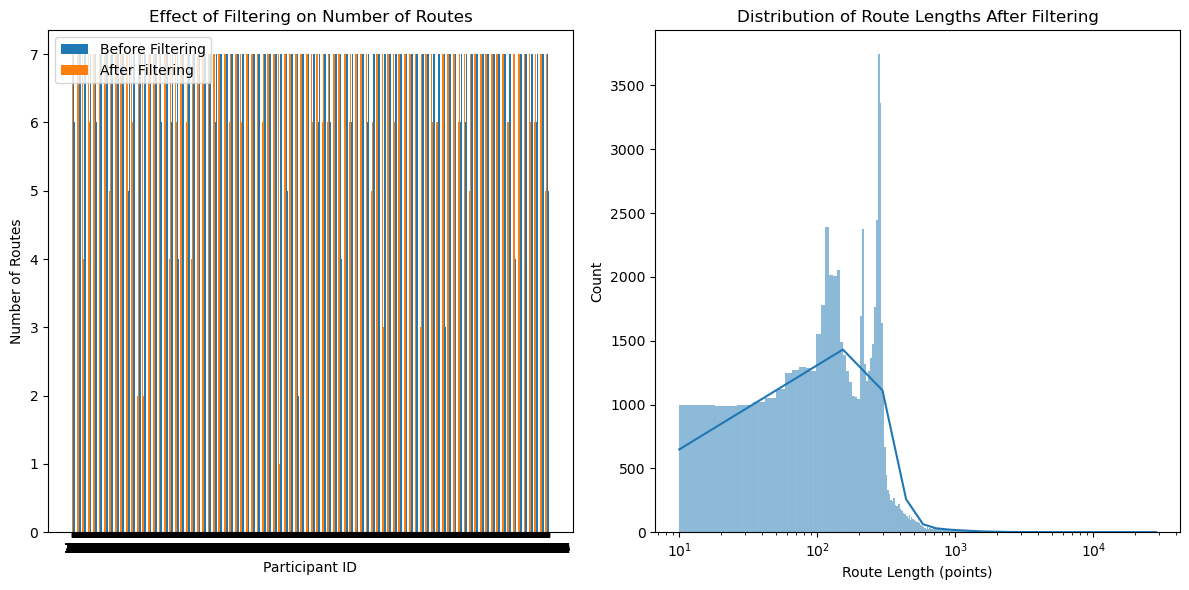

In [56]:
plt.figure(figsize=(12, 6))

# Compare number of routes before and after filtering
plt.subplot(1, 2, 1)
participant_ids = list(filtered_routes_by_participant.keys())

before_counts = [stats["total"] for p_id, stats in filter_stats["removed_routes_by_participant"].items() 
                if p_id in participant_ids]
after_counts = [stats["kept"] for p_id, stats in filter_stats["removed_routes_by_participant"].items() 
               if p_id in participant_ids]

x = np.arange(len(participant_ids))
width = 0.35

plt.bar(x - width/2, before_counts, width, label='Before Filtering')
plt.bar(x + width/2, after_counts, width, label='After Filtering')
plt.xlabel('Participant ID')
plt.ylabel('Number of Routes')
plt.title('Effect of Filtering on Number of Routes')
plt.xticks(x, participant_ids)
plt.legend()

# Distribution of route lengths after filtering
plt.subplot(1, 2, 2)
filtered_route_lengths = [len(df) for p_routes in filtered_routes_by_participant.values() 
                         for df in p_routes.values()]
sns.histplot(filtered_route_lengths, kde=True)
plt.xlabel('Route Length (points)')
plt.ylabel('Count')
plt.title('Distribution of Route Lengths After Filtering')
plt.xscale('log')

plt.tight_layout()
plt.show()

In [57]:
with open(os.path.join(PROCESSED_DATA_DIR, 'tdrive_next_point_separated_routes_by_day.pkl'), 'wb') as f:
    pickle.dump(separated_routes_by_participant, f)

print(f"Separated routes dataset saved to {os.path.join(PROCESSED_DATA_DIR, 'tdrive_next_point_separated_routes_by_day.pkl')}")

Separated routes dataset saved to processed\tdrive_next_point_separated_routes_by_day.pkl


In [58]:
with open(os.path.join(PROCESSED_DATA_DIR, 'tdrive_next_point_filtered_min_len_10_separated_routes_by_day.pkl'), 'wb') as f:
    pickle.dump(filtered_routes_by_participant, f)

print(f"Filtered dataset saved to {os.path.join(PROCESSED_DATA_DIR, 'tdrive_next_point_filtered_min_len_10_separated_routes_by_day.pkl')}")

Filtered dataset saved to processed\tdrive_next_point_filtered_min_len_10_separated_routes_by_day.pkl
